In [14]:
from math import cos, sin
from numpy import pi
from PIL import Image
from IPython.display import display, clear_output
import numpy as np
from numba import njit,prange

In [15]:
R = 10.0
n = 1.5 #number of twists
width = 0.5 #on each side

In [16]:
def mob_point(tm,w):
    x = w
    y = tm
    xcy2 = x*cos(n*y)
    return (((R + xcy2)*cos(y)), ((R + xcy2)*sin(y)), x*sin(n*y))

In [17]:
@njit
def tl1(tm, x0, y0, z0, vx, vy, vz): #vx, vy
    stm = sin(tm)
    ctm = cos(tm)
    return (x0*stm - y0*ctm)/(vy*ctm - vx*stm)

@njit
def tl2(tm, x0, y0, z0, vx, vy, vz):#vy, vz
    ntm = n*tm
    sntm = sin(ntm)
    stm = sin(tm)
    cntm = cos(ntm)
    return ((y0 - R*stm)*sntm - z0*stm*cntm)/(vz*stm*cntm - vy*sntm)

@njit
def tl3(tm, x0, y0, z0, vx, vy, vz):#vx, vz
    ntm = n*tm
    sntm = sin(ntm)
    cntm = cos(ntm)
    ctm = cos(tm)
    return ((x0 - R*ctm)*sntm - z0*ctm*cntm)/(vz*ctm*cntm - vx*sntm)

#for n = 3/2
critical_points = np.array([0.0, pi/3, pi/2, 2/3 * pi, pi, 4/3 * pi, 1.5*pi, 5/3*pi], dtype=np.float64)

In [18]:
@njit
def w1(tl, tm, x0, y0, z0, vx, vy, vz):
    return (x0 + vx*tl - R*cos(tm))/(cos(tm)*cos(n*tm))

@njit
def w2(tl, tm, x0, y0, z0, vx, vy, vz):
    return (y0 + vy*tl - R*sin(tm))/(sin(tm)*cos(n*tm))

@njit
def w3(tl, tm, x0, y0, z0, vx, vy, vz):
    return (z0 + vz*tl)/sin(n*tm)

In [19]:
@njit
def findw(tl, tm, x0, y0, z0, vx, vy, vz):
    try:
        return w1(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    try:
        return w2(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    try:
        return w3(tl, tm, x0, y0, z0, vx, vy, vz)
    except:
        pass
    
    return 2*width

In [20]:
@njit
def newton(guess, r0, v, verbose=False):
    tol = 1e-6
    
    x0,y0,z0 = r0[0], r0[1], r0[2]
    vx,vy,vz = v[0], v[1], v[2]
    
    if vx != 0:
#         e1 = tl1
#         e2 = tl3
        for i in range(40): 
            sx = tl1(guess, *r0, *v) - tl3(guess, *r0, *v)
            ds = (tl1(guess+tol, *r0, *v) - tl1(guess-tol, *r0, *v) - tl3(guess+tol, *r0, *v) + tl3(guess-tol, *r0, *v))/(2*tol)
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vy != 0:
#         e1 = tl1
#         e2 = tl2
        for i in range(40): 
            sx = tl1(guess, *r0, *v) - tl2(guess, *r0, *v)
            ds = (tl1(guess+tol, *r0, *v) - tl1(guess-tol, *r0, *v) - tl2(guess+tol, *r0, *v) + tl2(guess-tol, *r0, *v))/(2*tol)
#             if verbose:
#                 print("x = " + str(guess))
#                 print("sx = " + str(sx))
#                 print("ds(x) = " + str(ds))
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    elif vz != 0:
#         e1 = tl2
#         e2 = tl3
        for i in range(40): 
            sx = tl2(guess, *r0, *v) - tl3(guess, *r0, *v)
            ds = (tl2(guess+tol, *r0, *v) - tl2(guess-tol, *r0, *v) - tl3(guess+tol, *r0, *v) + tl3(guess-tol, *r0, *v))/(2*tol)
#             if verbose:
#                 print("x = " + str(guess))
#                 print("sx = " + str(sx))
#                 print("ds(x) = " + str(ds))
            guess -= sx/ds
        guess %= (2*pi)
        return guess
    else:
        return None
    
#     for i in range(40): 
#         sx = e1(guess, *r0, *v) - e2(guess, *r0, *v)
#         ds = (e1(guess+tol, *r0, *v) - e1(guess-tol, *r0, *v) - e2(guess+tol, *r0, *v) + e2(guess-tol, *r0, *v))/(2*tol)
#         if verbose:
#             print("x = " + str(guess))
#             print("sx = " + str(sx))
#             print("ds(x) = " + str(ds))
#         guess -= sx/ds
#     guess %= (2*pi)
# #     print(x)
#     return guess

In [21]:
@njit
def intersect(r0, v):
    x0,y0,z0 = r0[0], r0[1], r0[2]
    vx,vy,vz = v[0], v[1], v[2]
    
    angles = set()
    
    for tm in critical_points:
        ntm = n*tm
        ctm = cos(tm)
        stm = sin(tm)
        cntm = cos(ntm)
        sntm = sin(ntm)
        r1 = [cntm*ctm, -vx]
        r2 = [cntm*stm, -vy]
        r3 = [sntm, -vz]
        s1 = x0 - R*ctm
        s2 = y0 - R*stm
        s3 = z0

        e = 'LinAlgError'
        sols = []
        try:
            sol = np.linalg.solve(np.array([r1,r2]), np.array([s1,s2]))
            sols.append(sol)
        except:
            pass
        try:
            sol = np.linalg.solve(np.array([r2,r3]), np.array([s2,s3]))
            sols.append(sol)
        except:
            pass
        try:
            sol = np.linalg.solve(np.array([r3,r1]), np.array([s3,s1]))
            sols.append(sol)
        except:
            pass
        
        found = False
#         print(tm)
        
        if len(sols) == 1:
#             print(sols[0])
            found = True
        if len(sols) == 2:
            if np.all(sols[0] == sols[1]):
#                 print(sols[0])
                found = True

        if len(sols) == 3:
            if np.all(sols[0] == sols[1]) and np.all(sols[1] == sols[2]) :
#                 print(sols[0])
                found = True
        if found:
            angles.add(round(tm, 13))

        
    for i in range(1,64):
        try: 
            newt = newton(i*0.1, r0, v)
            nn = round(newt, 13)
            if nn <= 6.28318530718:
    #             print(nn)
                angles.add(nn)
        except:
#             print(i*0.1)
            pass
    hit = False;
#     print(angles)
    
    for a in angles:
#         print("\n" + str(a) + ":")
        try:
            tl = tl1(a, *r0, *v)
            xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
            w = findw(tl,a, *r0, *v)
#             print(str(tl) + ": " + str(xyz) + ", " + str(w))
            if(w >= -width and w <= width):
                hit = True
        except:
            pass
        
        try:
            tl = tl2(a, *r0, *v)
            xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
            w = findw(tl,a, *r0, *v)
#             print(str(tl) + ": " + str(xyz) + ", " + str(w))
            if(w >= -width and w <= width):
                hit = True
                
        except:
            pass
        
        try:
            tl = tl3(a, *r0, *v)
            xyz = (r0[0] + tl*v[0], r0[1] + tl*v[1], r0[2] + tl*v[2])
            w = findw(tl,a, *r0, *v)
#             print(str(tl) + ": " + str(xyz) + ", " + str(w))
            if(w >= -width and w <= width):
                hit = True
        except:
            pass
        
    return hit

In [22]:
@njit(parallel=True)
def main():
    im_size = 25 #units width
    ppu = 4 #pixels per unit
    size = im_size*ppu
    im_arr = np.zeros((size, size, 3), dtype = np.uint8)

    for i in range(size):
        print(i)
        for j in prange(size):
            x = (i/size - 0.5) * (im_size)
            y = (j/size - 0.5) * (im_size)
            z = 4.0

    #         v = np.asarray([0.0,0.0,-1.0], dtype=np.float64)
    #         r0 = np.asarray([x,y,z], dtype=np.float64)
            xv = (0.0,0.0,-1.0)
            xr0 = (x,y,z)
            hit = intersect(xr0,xv)
            if hit:
                im_arr[i][j] = np.asarray([255,255,255], dtype=np.uint8)
            else:
                im_arr[i][j] = np.asarray([0,0,0], dtype=np.uint8)
    #         print(hit, x, y, z)
    
    return im_arr
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


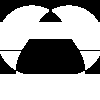

In [23]:
ia = main()
vf = Image.fromarray(ia)
display(vf)

In [24]:
x = -7.0
y = 10.0
z = 4.0

dv = (0.0, 0.0, -1.0)
dr0 = (x,y,z)
hit = intersect(dr0,dv)
print(hit, x, y, z)

True -7.0 10.0 4.0


In [ ]:
w1(4, 0, *dr0, *dv)